In [121]:
# Importaciones de bibliotecas estándar
import warnings
from datetime import datetime

# Importaciones de bibliotecas científicas y de manipulación de datos
import numpy as np
import pandas as pd
import tensorflow as tf

# Importaciones de bibliotecas para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones de scikit-learn
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import (confusion_matrix, precision_score, accuracy_score, 
                             recall_score, f1_score, roc_curve, auc)

# Importaciones de Keras y TensorFlow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import pad_sequences

# Configuración de advertencias
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR') 
warnings.filterwarnings('ignore', category=UserWarning)


In [3]:
datos_pacientes = []
grd_pacientes = []
edad = []
sexo = []
archivo1 = open("dataset/dataset_elpino.csv", encoding="utf-8")
encabezado = archivo1.readline().strip().split(";")
campos = []
df_visual = pd.read_csv("dataset/dataset_elpino.csv", sep= ';')
df_visual

,Diag 01 Principal (cod+des),Diag 02 Secundario (cod+des),Diag 03 Secundario (cod+des),Diag 04 Secundario (cod+des),Diag 05 Secundario (cod+des),Diag 06 Secundario (cod+des),Diag 07 Secundario (cod+des),Diag 08 Secundario (cod+des),Diag 09 Secundario (cod+des),Diag 10 Secundario (cod+des),...,Proced 24 Secundario (cod+des),Proced 25 Secundario (cod+des),Proced 26 Secundario (cod+des),Proced 27 Secundario (cod+des),Proced 28 Secundario (cod+des),Proced 29 Secundario (cod+des),Proced 30 Secundario (cod+des),Edad en años,Sexo (Desc),GRD
0,A41.8 - Otras septicemias especificadas,B37.6 - Endocarditis debida a candida (I39.8*),"I39.8 - Endocarditis, válvula no especificada,...",N10 - Nefritis tubulointersticial aguda,B96.1 - Klebsiella pneumoniae [K. pneumoniae] ...,L89.9 - Úlcera de decúbito y area de presión n...,L08.9 - Infección local de la piel y del tejid...,B96.2 - Escherichia coli [E. coli] como causa ...,A41.5 - Sepsis por otros organnismos Gram nega...,J86.9 - Piotórax sin fístula,...,99.84 - AISLAMIENTO,88.72 - ECOCARDIOGRAFIA,90.42 - EXAMEN MICROSCOPICO RESPIRATORIO.CULTIVO,90.52 - EXAMEN MICROSCOPICO SANGRE.CULTIVO,91.39 - EXAMEN MICROSCOPICO URINARIO INFERIOR....,91.33 - EXAMEN MICROSCOPICO URINARIO INFERIOR....,87.03 - TOMOGRAFIA AXIAL COMPUTERIZADA CABEZA,40,Hombre,184103 - MH SEPTICEMIA W/MCC
1,"U07.1 - COVID-19, virus identificado",J12.8 - Neumonía debida a otros virus,R06.0 - Disnea,R05 - Tos,"R50.9 - Fiebre, no especificada",Z29.0 - Aislamiento,Z01.7 - Examen de laboratorio,"J96.00 - Insuficiencia respiratoria aguda, Tip...",J94.2 - Hemotórax,J92.9 - Paquipleuritis sin asbestosis,...,91.62 - EXAMEN MICROSCOPICO PIEL.CULTIVO,90.43 - EXAMEN MICROSCOPICO RESPIRATORIO.CULTI...,91.39 - EXAMEN MICROSCOPICO URINARIO INFERIOR....,90.52 - EXAMEN MICROSCOPICO SANGRE.CULTIVO,91.32 - EXAMEN MICROSCOPICO URINARIO INFERIOR....,96.59 - IRRIGACION HERIDA OTRA,90.99 - EXAMEN MICROSCOPICO DIGESTIVO INFERIOR...,53,Hombre,041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...
2,K56.5 - Adherencias [bridas] intestinales con ...,R57.2 - Shock séptico,R57.1 - Choque hipovolémico,J80 - Síndrome de dificultad respiratoria del ...,Y95 - Afección nosocomial,J15.0 - Neumonía debida a Klebsiella pneumoniae,U82.2 - Resistencia a Betalactamasas de amplio...,B95.6 - Staphylococcus aureus como causa de en...,B96.8 - Otros agentes bacterianos especificado...,B37.1 - Candidiasis pulmonar,...,99.84 - AISLAMIENTO,91.73 - EXAMEN MICROSCOPICO HERIDA OPERATORIA....,90.53 - EXAMEN MICROSCOPICO SANGRE.CULTIVO Y S...,99.26 - INYECCION TRANQUILIZANTE,89.39 - OTRAS MEDICIONES Y EXAMENES NO QUIRURG...,89.66 - GASOMETRIA VENA,89.65 - GASOMETRIA ARTERIA,65,Hombre,041013 - PH ECMO VENTILACIÓN MECÁNICA PROLONGA...
3,K76.8 - Otras enfermedades especificadas del h...,K66.1 - Hemoperitoneo,"N18.5 - Enfermedad renal crónica, estadio 5",D64.9 - Anemia de tipo no especificado,E87.5 - Hiperpotasemia,E87.2 - Acidosis,J81 - Edema pulmonar,N17.8 - Otras insuficiencias renales agudas,J44.9 - Enfermedad pulmonar obstructiva crónic...,R41.0 - Desorientación no especificada,...,57.94 - SONDAJE URINARIO PERMANENTE,00.13 - INYECCION NESIRITIDE,00.17 - INFUSON AGENTE VASOPRESOR,99.04 - TRANSFUSION CONCENTRADO HEMATIES,99.18 - INYECCION ELECTROLITO,99.21 - INYECCION ANTIBIOTICO,99.23 - INYECCION ESTEROIDE,61,Hombre,041023 - PH VENTILACIÓN MECÁNICA PROLONGADA SI...
4,T81.0 - Hemorragia y hematoma que complican un...,"Y83.2 - Operación quirúrgica con anastomosis, ...",S31.1 - Herida de la pared abdominal,S36.80 - Traumatismo de otros órganos intraabd...,W31.62 - Contacto traumático con otras maquina...,"J96.09 - Insuficiencia respiratoria aguda, Tip...",J15.0 - Neumonía debida a Klebsiella pneumoniae,U82.2 - Resistencia a Betalactamasas de amplio...,"U07.1 - COVID-19, virus identificado","N39.0 - Infección de vías urinarias, sitio no ...",...,90.52 - EXAMEN MICROSCOPICO SANGRE.CULTIVO,91.39 - EXAMEN MICROSCOPICO URINARIO INFERIOR....,91.32 - EXAMEN MICROSCOPICO URINARIO INFERIOR....,93.

In [4]:
for columna in encabezado:
    columna = columna.split("-")[0].strip()
    if columna.startswith("Diag") or columna.startswith("Proc"):
        columna = columna.split(" ")
        columna = columna[0] + columna[1]
    campos.append(columna)

# Lectura línea por línea del archivo
for linea in archivo1:
    datos_ficha = []
    linea = linea.strip().split(";")
    for i in range(len(linea)):
        dato = linea[i].split("-")[0].strip()
        if i == 67:  # Campo GRD
            grd = dato
            grd_pacientes.append(grd)
        elif i == 66:  # Campo Sexo
            sexo.append(1 if dato == "Mujer" else 0)
        elif i == 65:  # Campo Edad
            edad.append(int(dato))
        else:
            datos_ficha.append(dato)
    datos_pacientes.append(datos_ficha)

In [6]:
df = pd.DataFrame(datos_pacientes, columns=campos[:-3])
df["GRD"] = grd_pacientes
df

,﻿Diag 01 Principal (cod+des),Diag02,Diag03,Diag04,Diag05,Diag06,Diag07,Diag08,Diag09,Diag10,...,Proced22,Proced23,Proced24,Proced25,Proced26,Proced27,Proced28,Proced29,Proced30,GRD
0,A41.8,B37.6,I39.8,N10,B96.1,L89.9,L08.9,B96.2,A41.5,J86.9,...,99.04,90.39,99.84,88.72,90.42,90.52,91.39,91.33,87.03,184103
1,U07.1,J12.8,R06.0,R05,R50.9,Z29.0,Z01.7,J96.00,J94.2,J92.9,...,91.69,87.44,91.62,90.43,91.39,90.52,91.32,96.59,90.99,041013
2,K56.5,R57.2,R57.1,J80,Y95,J15.0,U82.2,B95.6,B96.8,B37.1,...,91.33,90.39,99.84,91.73,90.53,99.26,89.39,89.66,89.65,041013
3,K76.8,K66.1,N18.5,D64.9,E87.5,E87.2,J81,N17.8,J44.9,R41.0,...,96.59,94.19,57.94,00.13,00.17,99.04,99.18,99.21,99.23,041023
4,T81.0,Y83.2,S31.1,S36.80,W31.62,J96.09,J15.0,U82.2,U07.1,N39.0,...,99.21,99.29,90.52,91.39,91.32,93.90,99.15,96.59,45.13,041023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14556,E10.1,J45.9,F10.2,F17.2,Z91.1,,,,,,...,,,,,,,,,,104101
14557,S09.9,W18.24,R55,,,,,,,,...,,,,,,,,,,014242
14558,K92.1,I10,E11.9,I50.9,K25.9,M16.9,G47.3,Z99.8,,,...,,,,,,,,,,064182
14559,E78.1,I10,Z92.2,,,,,,,,...,,,,,,,,,,104121


In [7]:
filtro = (df["GRD"]=='146101') | (df["GRD"]=='146102') | (df["GRD"]=='146103')
datos_filtrados = df[filtro]

,﻿Diag 01 Principal (cod+des),Diag02,Diag03,Diag04,Diag05,Diag06,Diag07,Diag08,Diag09,Diag10,...,Proced22,Proced23,Proced24,Proced25,Proced26,Proced27,Proced28,Proced29,Proced30,GRD
0,A41.8,B37.6,I39.8,N10,B96.1,L89.9,L08.9,B96.2,A41.5,J86.9,...,99.04,90.39,99.84,88.72,90.42,90.52,91.39,91.33,87.03,184103
1,U07.1,J12.8,R06.0,R05,R50.9,Z29.0,Z01.7,J96.00,J94.2,J92.9,...,91.69,87.44,91.62,90.43,91.39,90.52,91.32,96.59,90.99,041013
2,K56.5,R57.2,R57.1,J80,Y95,J15.0,U82.2,B95.6,B96.8,B37.1,...,91.33,90.39,99.84,91.73,90.53,99.26,89.39,89.66,89.65,041013
3,K76.8,K66.1,N18.5,D64.9,E87.5,E87.2,J81,N17.8,J44.9,R41.0,...,96.59,94.19,57.94,00.13,00.17,99.04,99.18,99.21,99.23,041023
4,T81.0,Y83.2,S31.1,S36.80,W31.62,J96.09,J15.0,U82.2,U07.1,N39.0,...,99.21,99.29,90.52,91.39,91.32,93.90,99.15,96.59,45.13,041023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14556,E10.1,J45.9,F10.2,F17.2,Z91.1,,,,,,...,,,,,,,,,,104101
14557,S09.9,W18.24,R55,,,,,,,,...,,,,,,,,,,014242
14558,K92.1,I10,E11.9,I50.9,K25.9,M16.9,G47.3,Z99.8,,,...,,,,,,,,,,064182
14559,E78.1,I10,Z92.2,,,,,,,,...,,,,,,,,,,104121


In [8]:
print("Nombres de columnas en el DataFrame:")
print(df.columns.tolist()[:10]) 

Nombres de columnas en el DataFrame:
['\ufeffDiag 01 Principal (cod+des)', 'Diag02', 'Diag03', 'Diag04', 'Diag05', 'Diag06', 'Diag07', 'Diag08', 'Diag09', 'Diag10']


In [9]:
columnas_diagnosticos = [col for col in df.columns if 'Diag' in col]
columnas_procedimientos = [col for col in df.columns if 'Proced' in col]

In [10]:
diagnosticos = {}
procedimientos = {}

for i, fila in datos_filtrados.iterrows():
    # Procesamiento de diagnósticos
    for columna in columnas_diagnosticos:
        if fila[columna] not in diagnosticos:
            diagnosticos[fila[columna]] = 1
        else:
            diagnosticos[fila[columna]] += 1
    
    for columna in columnas_procedimientos:
        if fila[columna] not in procedimientos:
            procedimientos[fila[columna]] = 1
        else:
            procedimientos[fila[columna]] += 1

In [11]:
# Crear vocabulario
codigos_diagnosticos = list(diagnosticos.keys())
codigos_procedimientos = list(procedimientos.keys())
tamano_vocabulario = len(codigos_diagnosticos) + len(codigos_procedimientos) + 1

print("Diagnósticos únicos:", len(codigos_diagnosticos))
print("Procedimientos únicos:", len(codigos_procedimientos))
print("Tamaño del vocabulario:", tamano_vocabulario)

Diagnósticos únicos: 377
Procedimientos únicos: 155
Tamaño del vocabulario: 533


In [12]:
# Tokenización de los datos
fichas_numericas = []
columnas_diagnosticos = [col for col in datos_filtrados.columns if 'Diag' in col]
columnas_procedimientos = [col for col in datos_filtrados.columns if 'Proced' in col]

for i, fila in datos_filtrados.iterrows():
    ficha_numerica = []
    # Procesar diagnósticos
    for columna in columnas_diagnosticos:
        ficha_numerica.append(1 + codigos_diagnosticos.index(fila[columna]))
    for columna in columnas_procedimientos:
        ficha_numerica.append(1 + len(codigos_diagnosticos) + 
                            codigos_procedimientos.index(fila[columna]))
    fichas_numericas.append(ficha_numerica)

### Entrenar Modelo

In [13]:
# Preparación final de los datos
X = pad_sequences(fichas_numericas)
Y = datos_filtrados["GRD"].apply(lambda x: int(x)).to_numpy()

In [14]:
# Codificación de las etiquetas
codificador = LabelEncoder()
Y = codificador.fit_transform(Y)
Y = Y.reshape(-1, 1)
codificador_onehot = OneHotEncoder()
Y = codificador_onehot.fit_transform(Y).todense()


In [15]:
# División de datos en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=0)

In [16]:
# Creación del modelo LSTM
modelo_lstm = Sequential()
modelo_lstm.add(Embedding(input_dim=tamano_vocabulario, output_dim=64))
modelo_lstm.add(LSTM(32))
modelo_lstm.add(Dense(Y.shape[1], activation="softmax"))

modelo_lstm.compile(optimizer="Adam",
                   loss="categorical_crossentropy",
                   metrics=["acc"])

In [17]:
# Configuración de callbacks para el entrenamiento
tag = "lstm_" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_acc", 
                                                         patience=4,
                                                         restore_best_weights=True)


In [18]:
# Entrenamiento del modelo
historia_lstm = modelo_lstm.fit(x_train, y_train, 
                              validation_data=(x_val, y_val),
                              batch_size=32, epochs=16, verbose=2,
                              callbacks=[tensorboard_callback, earlystopping_callback])

Epoch 1/16
29/29 - 3s - 98ms/step - acc: 0.6503 - loss: 0.9016 - val_acc: 0.6689 - val_loss: 0.8773
Epoch 2/16
29/29 - 0s - 14ms/step - acc: 0.6667 - loss: 0.8495 - val_acc: 0.6689 - val_loss: 0.8489
Epoch 3/16
29/29 - 0s - 14ms/step - acc: 0.6699 - loss: 0.8412 - val_acc: 0.6721 - val_loss: 0.8175
Epoch 4/16
29/29 - 0s - 14ms/step - acc: 0.6776 - loss: 0.8002 - val_acc: 0.7148 - val_loss: 0.7187
Epoch 5/16
29/29 - 0s - 14ms/step - acc: 0.7213 - loss: 0.6802 - val_acc: 0.8000 - val_loss: 0.5412
Epoch 6/16
29/29 - 0s - 14ms/step - acc: 0.7552 - loss: 0.6119 - val_acc: 0.8066 - val_loss: 0.5240
Epoch 7/16
29/29 - 0s - 13ms/step - acc: 0.7716 - loss: 0.5514 - val_acc: 0.8131 - val_loss: 0.4912
Epoch 8/16
29/29 - 0s - 14ms/step - acc: 0.8208 - loss: 0.4604 - val_acc: 0.8590 - val_loss: 0.4053
Epoch 9/16
29/29 - 0s - 14ms/step - acc: 0.8721 - loss: 0.3859 - val_acc: 0.8689 - val_loss: 0.3545
Epoch 10/16
29/29 - 0s - 13ms/step - acc: 0.8842 - loss: 0.3455 - val_acc: 0.8328 - val_loss: 0.5246

In [21]:
# Guardar el modelo
modelo_lstm.save(f'modelos/modelo_{tag}.keras')

In [22]:
# Predicciones y evaluación
y_pred_probs = modelo_lstm.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_val_1d = np.squeeze(np.asarray(np.argmax(y_val, axis=1)))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


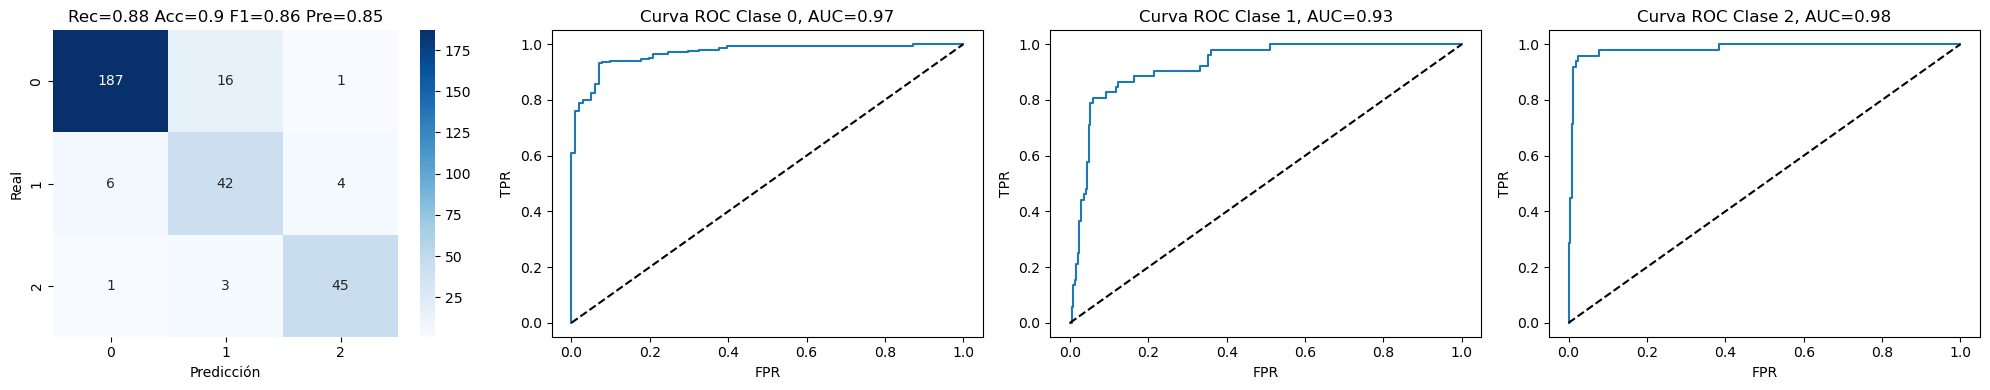

In [23]:
# Visualización de resultados
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 4)

# Matriz de confusión
matriz_ltsm = confusion_matrix(y_val_1d, y_pred)
ax = axes[0]
sns.heatmap(matriz_ltsm, annot=True, ax=ax, cmap="Blues", fmt="d")
ax.set_title("Rec=" + str(round(recall_score(y_val_1d, y_pred, average="macro"), 2)) +
             " Acc=" + str(round(accuracy_score(y_val_1d, y_pred), 2)) +
             " F1=" + str(round(f1_score(y_val_1d, y_pred, average="macro"), 2)) +
             " Pre=" + str(round(precision_score(y_val_1d, y_pred, average="macro"), 2)))
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Curvas ROC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.asarray(y_val[:, i]), 
                                 np.asarray(y_pred_probs[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes[i+1].plot(fpr[i], tpr[i])
    axes[i+1].plot([0, 1], [0, 1], 'k--')
    axes[i+1].set_xlabel('FPR')
    axes[i+1].set_ylabel('TPR')
    axes[i+1].set_title(f'Curva ROC Clase {i}, AUC={round(roc_auc[i],2)}')

plt.tight_layout()
plt.show()

In [ ]:
for i in range(3):
    print(f"Clase {i}:")
    print("ACC=", round(accuracy_score(np.squeeze(np.asarray(y_val[:,i])), 
                                     y_pred_probs[:,i] >= 0.5), 2),
          "PRE=", round(precision_score(np.squeeze(np.asarray(y_val[:,i])), 
                                      y_pred_probs[:,i] >= 0.5), 2),
          "REC=", round(recall_score(np.squeeze(np.asarray(y_val[:,i])), 
                                   y_pred_probs[:,i] >= 0.5), 2))

Clase 0:
ACC= 0.92 PRE= 0.96 REC= 0.92
Clase 1:
ACC= 0.91 PRE= 0.7 REC= 0.81
Clase 2:
ACC= 0.97 PRE= 0.9 REC= 0.92


### Modelo 2

In [ ]:
modelo_emb = Sequential()
modelo_emb.add(Embedding(input_dim=tamano_vocabulario, output_dim=64))
modelo_emb.add(GlobalAveragePooling1D())
modelo_emb.add(Dense(64, activation='relu'))
modelo_emb.add(Dense(Y.shape[1], activation="softmax"))
modelo_emb.compile(optimizer="Adam",
                  loss="categorical_crossentropy",
                  metrics=["acc"])


In [29]:
tag = "emb_" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_acc",
                                                         patience=4,
                                                         restore_best_weights=True)

In [30]:
#Guardar el modelo
modelo_emb.save(f'modelos/modelo_{tag}.keras')

c:\Users\fiton\anaconda3\Lib\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [31]:
# Predicciones y evaluación
y_pred_probs = modelo_emb.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_val_1d = np.squeeze(np.asarray(np.argmax(y_val, axis=1)))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


c:\Users\fiton\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


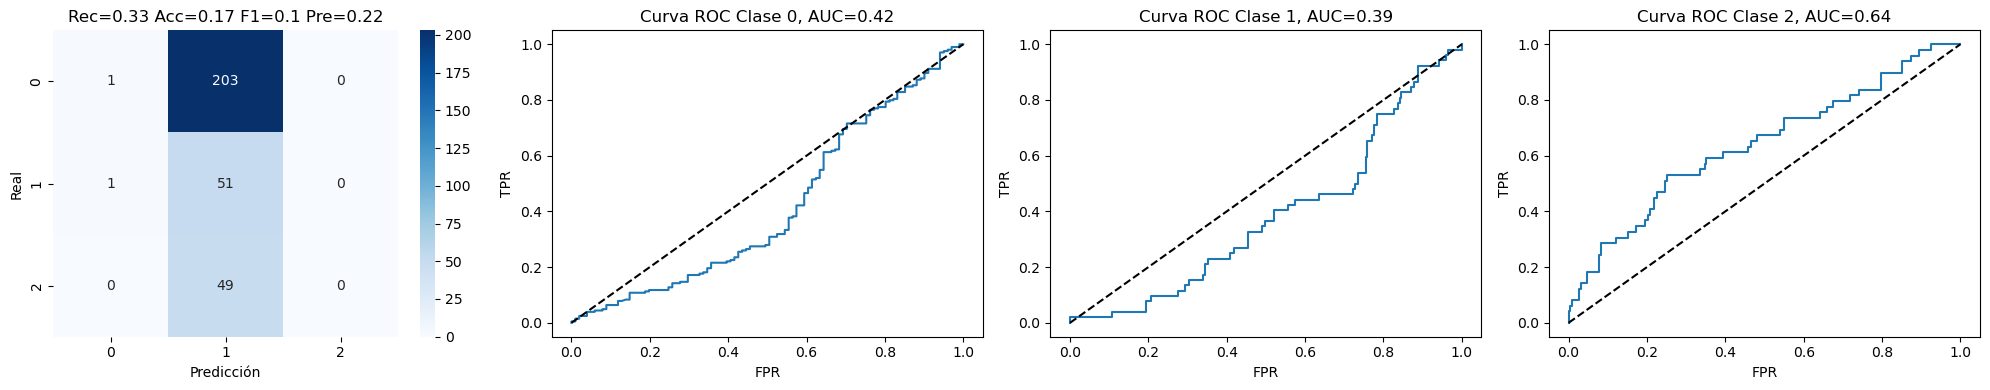

In [32]:
# Visualización de resultados
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 4)

# Matriz de confusión
matriz = confusion_matrix(y_val_1d, y_pred)
ax = axes[0]
sns.heatmap(matriz, annot=True, ax=ax, cmap="Blues", fmt="d")
ax.set_title("Rec=" + str(round(recall_score(y_val_1d, y_pred, average="macro"), 2)) +
             " Acc=" + str(round(accuracy_score(y_val_1d, y_pred), 2)) +
             " F1=" + str(round(f1_score(y_val_1d, y_pred, average="macro"), 2)) +
             " Pre=" + str(round(precision_score(y_val_1d, y_pred, average="macro"), 2)))
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Curvas ROC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.asarray(y_val[:, i]), 
                                 np.asarray(y_pred_probs[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes[i+1].plot(fpr[i], tpr[i])
    axes[i+1].plot([0, 1], [0, 1], 'k--')
    axes[i+1].set_xlabel('FPR')
    axes[i+1].set_ylabel('TPR')
    axes[i+1].set_title(f'Curva ROC Clase {i}, AUC={round(roc_auc[i],2)}')

plt.tight_layout()
plt.show()

In [ ]:
for i in range(3):
    print(f"Clase {i}:")
    print("ACC=", round(accuracy_score(np.squeeze(np.asarray(y_val[:,i])), 
                                     y_pred_probs[:,i] >= 0.5), 2),
          "PRE=", round(precision_score(np.squeeze(np.asarray(y_val[:,i])), 
                                      y_pred_probs[:,i] >= 0.5), 2),
          "REC=", round(recall_score(np.squeeze(np.asarray(y_val[:,i])), 
                                   y_pred_probs[:,i] >= 0.5), 2))

Clase 0:
ACC= 0.33 PRE= 0.0 REC= 0.0
Clase 1:
ACC= 0.83 PRE= 0.0 REC= 0.0
Clase 2:
ACC= 0.84 PRE= 0.0 REC= 0.0


c:\Users\fiton\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fiton\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fiton\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modelo 3

In [34]:
#modelo transformer
inputs = Input(shape=(X.shape[1],))
embedding = Embedding(input_dim=tamano_vocabulario, output_dim=64)(inputs)

In [35]:
# Bloque de atención
attention = MultiHeadAttention(num_heads=2, key_dim=32)(embedding, embedding)
attention = Dropout(0.1)(attention)
attention = LayerNormalization(epsilon=1e-6)(attention)

In [36]:
# Feed-forward network
ff = Dense(64, activation="relu")(attention)
ff = Dense(64)(ff)
ff = Dropout(0.1)(ff)
ff = LayerNormalization(epsilon=1e-6)(ff)

In [37]:
# Capa final
pooling = GlobalAveragePooling1D()(ff)
outputs = Dense(Y.shape[1], activation="softmax")(pooling)

In [38]:
# Construimos el modelo
modelo_transformer = Model(inputs=inputs, outputs=outputs)

In [39]:
# Compilación
modelo_transformer.compile(optimizer="Adam",
                         loss="categorical_crossentropy",
                         metrics=["acc"])

In [40]:
# Configuración del entrenamiento
tag = "transformer_" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag

# Callbacks para el entrenamiento
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_acc",
                                                         patience=4,
                                                         restore_best_weights=True)


In [41]:
# Entrenamiento del modelo
historia_transformer = modelo_transformer.fit(x_train, y_train,
                                           validation_data=(x_val, y_val),
                                           batch_size=32, epochs=16, verbose=2,
                                           callbacks=[tensorboard_callback, 
                                                    earlystopping_callback])

Epoch 1/16
29/29 - 3s - 117ms/step - acc: 0.6328 - loss: 0.9504 - val_acc: 0.6689 - val_loss: 0.8704
Epoch 2/16
29/29 - 0s - 13ms/step - acc: 0.6656 - loss: 0.8630 - val_acc: 0.6689 - val_loss: 0.8662
Epoch 3/16
29/29 - 0s - 14ms/step - acc: 0.6656 - loss: 0.8589 - val_acc: 0.6689 - val_loss: 0.8716
Epoch 4/16
29/29 - 0s - 14ms/step - acc: 0.6656 - loss: 0.8474 - val_acc: 0.6689 - val_loss: 0.8072
Epoch 5/16
29/29 - 0s - 14ms/step - acc: 0.7093 - loss: 0.6972 - val_acc: 0.8230 - val_loss: 0.4304
Epoch 6/16
29/29 - 0s - 14ms/step - acc: 0.8230 - loss: 0.4434 - val_acc: 0.8754 - val_loss: 0.3286
Epoch 7/16
29/29 - 0s - 14ms/step - acc: 0.9202 - loss: 0.2519 - val_acc: 0.8033 - val_loss: 0.4971
Epoch 8/16
29/29 - 0s - 14ms/step - acc: 0.9279 - loss: 0.2072 - val_acc: 0.9148 - val_loss: 0.2707
Epoch 9/16
29/29 - 0s - 14ms/step - acc: 0.9454 - loss: 0.1541 - val_acc: 0.9049 - val_loss: 0.3527
Epoch 10/16
29/29 - 0s - 13ms/step - acc: 0.9475 - loss: 0.1501 - val_acc: 0.8689 - val_loss: 0.411

In [42]:
# Guardamos el modelo entrenado
modelo_transformer.save(f'modelos/modelo_{tag}.keras')

In [43]:
# Evaluación del modelo
y_pred_probs = modelo_transformer.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_val_1d = np.squeeze(np.asarray(np.argmax(y_val, axis=1)))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


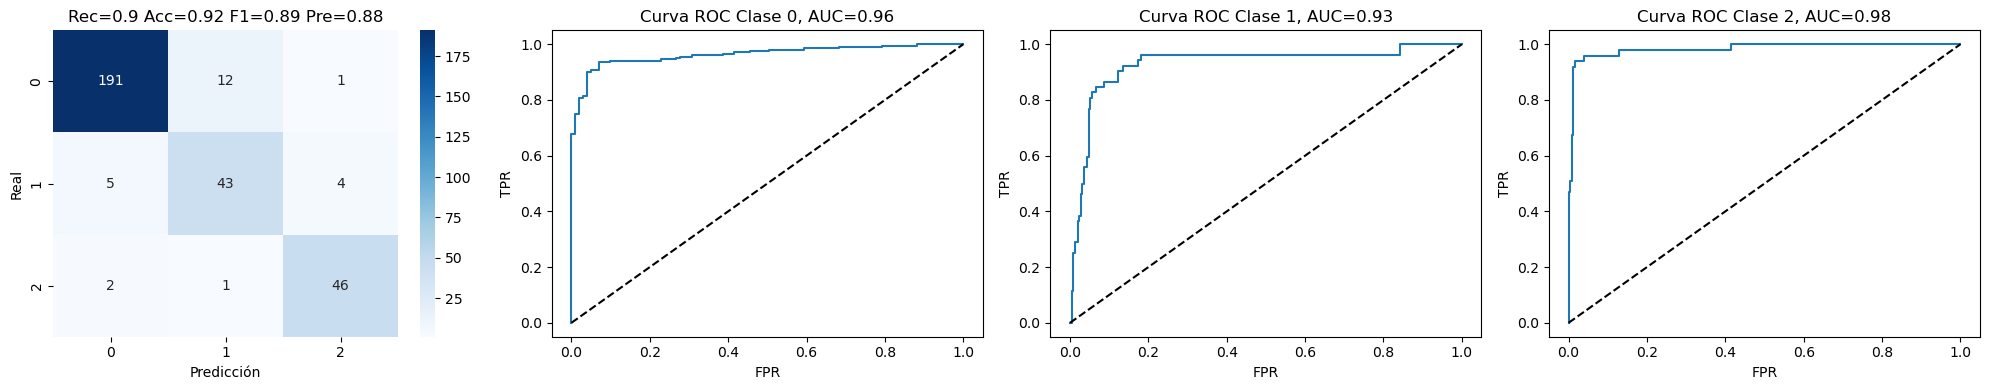

In [ ]:
# Visualización de resultados: creamos una figura con 4 subplots
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 4)

# Matriz de confusión
matriz = confusion_matrix(y_val_1d, y_pred)
ax = axes[0]
sns.heatmap(matriz, annot=True, ax=ax, cmap="Blues", fmt="d")
ax.set_title("Rec=" + str(round(recall_score(y_val_1d, y_pred, average="macro"), 2)) +
            " Acc=" + str(round(accuracy_score(y_val_1d, y_pred), 2)) +
            " F1=" + str(round(f1_score(y_val_1d, y_pred, average="macro"), 2)) +
            " Pre=" + str(round(precision_score(y_val_1d, y_pred, average="macro"), 2)))
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Curvas ROC 
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
   fpr[i], tpr[i], _ = roc_curve(np.asarray(y_val[:, i]), 
                                np.asarray(y_pred_probs[:, i]))
   roc_auc[i] = auc(fpr[i], tpr[i])
   
   axes[i+1].plot(fpr[i], tpr[i])
   axes[i+1].plot([0, 1], [0, 1], 'k--')
   axes[i+1].set_xlabel('FPR')
   axes[i+1].set_ylabel('TPR')
   axes[i+1].set_title(f'Curva ROC Clase {i}, AUC={round(roc_auc[i],2)}')

plt.tight_layout()
plt.show()


In [ ]:
# Imprimimos las métricas
for i in range(3):
   print(f"Clase {i}:")
   print("ACC=", round(accuracy_score(np.squeeze(np.asarray(y_val[:,i])), 
                                    y_pred_probs[:,i] >= 0.5), 2),
         "PRE=", round(precision_score(np.squeeze(np.asarray(y_val[:,i])), 
                                     y_pred_probs[:,i] >= 0.5), 2),
         "REC=", round(recall_score(np.squeeze(np.asarray(y_val[:,i])), 
                                  y_pred_probs[:,i] >= 0.5), 2))

Clase 0:
ACC= 0.93 PRE= 0.96 REC= 0.94
Clase 1:
ACC= 0.92 PRE= 0.76 REC= 0.81
Clase 2:
ACC= 0.97 PRE= 0.9 REC= 0.94


#### Busqueda de mejores parametros gridsearch

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=0)

In [73]:
def entrenar_y_evaluar_modelo(parametros):
    modelo = crear_modelo_lstm(
        tamano_vocabulario=tamano_vocabulario,
        output_dim=parametros['output_dim'],
        lstm_units=parametros['lstm_units'],
        optimizer=parametros['optimizer'],
        dropout=parametros['dropout']
    )
    historia = modelo.fit(
        x_train, y_train,
        batch_size=parametros['batch_size'],
        epochs=parametros['epochs'],
        validation_data=(x_val, y_val),
        verbose=0
    )
    y_pred_probs = modelo.predict(x_val, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_val_1d = np.asarray(np.argmax(y_val, axis=1))  
    y_pred = np.asarray(y_pred)  
    acc = accuracy_score(y_val_1d, y_pred)
    return acc, modelo, historia


In [74]:
# Definir los parámetros a buscar
parametros = {
    'output_dim': [32, 64, 128],
    'lstm_units': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'dropout': [0.0, 0.2, 0.5],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

# Generar todas las combinaciones
combinaciones = list(product(
    parametros['output_dim'],
    parametros['lstm_units'],
    parametros['optimizer'],
    parametros['dropout'],
    parametros['batch_size'],
    parametros['epochs']
))

# Convertir combinaciones a un formato legible
combinaciones = [
    {
        'output_dim': c[0],
        'lstm_units': c[1],
        'optimizer': c[2],
        'dropout': c[3],
        'batch_size': c[4],
        'epochs': c[5]
    }
    for c in combinaciones
]


In [75]:
resultados = []

for i, params in enumerate(combinaciones):
    print(f"Entrenando modelo {i+1}/{len(combinaciones)} con parámetros: {params}")
    acc, modelo, historia = entrenar_y_evaluar_modelo(params)
    resultados.append({'params': params, 'accuracy': acc})
    print(f"Exactitud obtenida: {acc:.4f}")


Entrenando modelo 1/216 con parámetros: {'output_dim': 32, 'lstm_units': 32, 'optimizer': 'adam', 'dropout': 0.0, 'batch_size': 32, 'epochs': 10}
Exactitud obtenida: 0.8295
Entrenando modelo 2/216 con parámetros: {'output_dim': 32, 'lstm_units': 32, 'optimizer': 'adam', 'dropout': 0.0, 'batch_size': 32, 'epochs': 20}
Exactitud obtenida: 0.8197
Entrenando modelo 3/216 con parámetros: {'output_dim': 32, 'lstm_units': 32, 'optimizer': 'adam', 'dropout': 0.0, 'batch_size': 64, 'epochs': 10}
Exactitud obtenida: 0.7934
Entrenando modelo 4/216 con parámetros: {'output_dim': 32, 'lstm_units': 32, 'optimizer': 'adam', 'dropout': 0.0, 'batch_size': 64, 'epochs': 20}
Exactitud obtenida: 0.8262
Entrenando modelo 5/216 con parámetros: {'output_dim': 32, 'lstm_units': 32, 'optimizer': 'adam', 'dropout': 0.2, 'batch_size': 32, 'epochs': 10}
Exactitud obtenida: 0.8656
Entrenando modelo 6/216 con parámetros: {'output_dim': 32, 'lstm_units': 32, 'optimizer': 'adam', 'dropout': 0.2, 'batch_size': 32, 'ep

In [76]:
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='accuracy', ascending=False)
print("Mejores parámetros encontrados:")
print(df_resultados.iloc[0])


Mejores parámetros encontrados:
params      {'output_dim': 32, 'lstm_units': 64, 'optimize...
accuracy                                             0.911475
Name: 41, dtype: object


In [77]:
mejores_params = df_resultados.iloc[0]['params']
_, modelo_final, historia_final = entrenar_y_evaluar_modelo(mejores_params)
modelo_final.save("modelo_lstm_mejorado.h5")


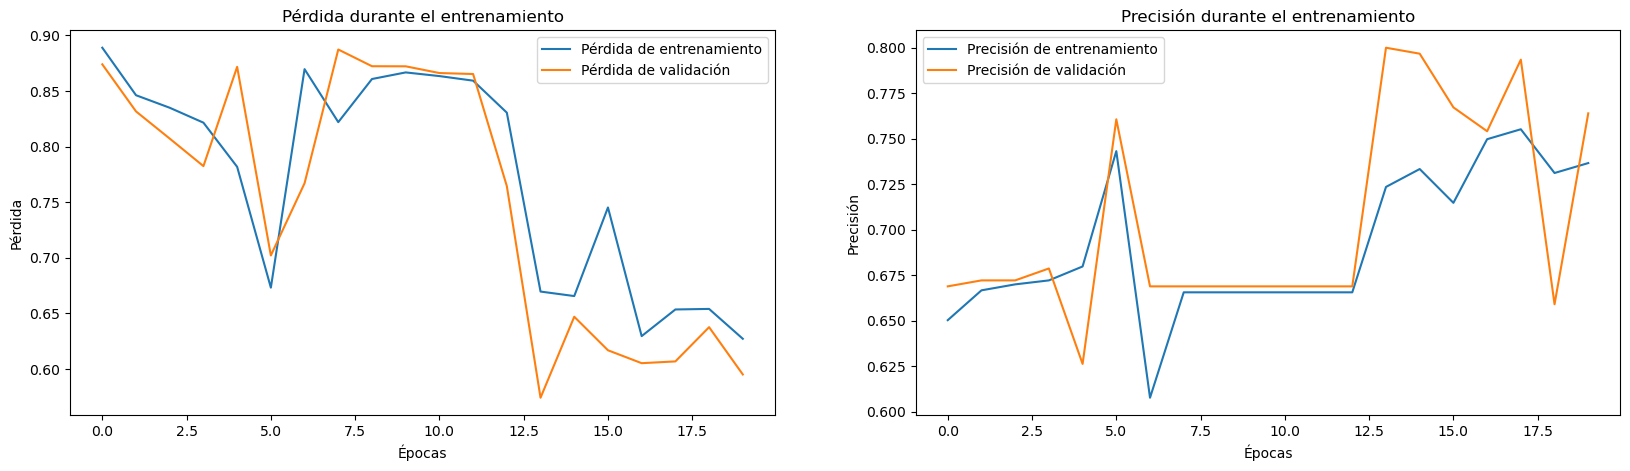

In [90]:
# Visualización de la precisión, pérdida y curvas ROC
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Pérdida durante el entrenamiento
axes[0].plot(historia_final.history['loss'], label='Pérdida de entrenamiento')
axes[0].plot(historia_final.history['val_loss'], label='Pérdida de validación')
axes[0].set_title('Pérdida durante el entrenamiento')
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Pérdida')
axes[0].legend()

# Precisión durante el entrenamiento
axes[1].plot(historia_final.history['accuracy'], label='Precisión de entrenamiento')
axes[1].plot(historia_final.history['val_accuracy'], label='Precisión de validación')
axes[1].set_title('Precisión durante el entrenamiento')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Precisión')
axes[1].legend()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


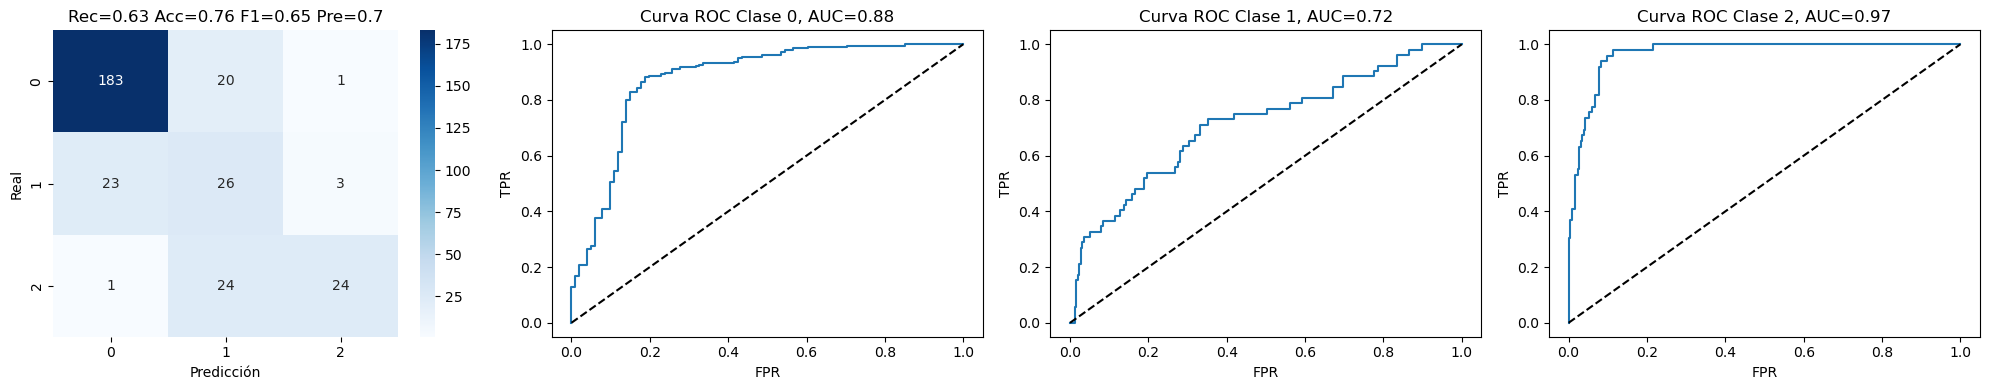

In [ ]:
y_pred = modelo_final.predict(x_val)  
if y_pred.shape[1] > 1:  
    y_pred_probs = y_pred  
else
    y_pred_probs = np.hstack([1 - y_pred, y_pred])

#Visualización de resultados
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 4)

#Matriz de confusión
matriz = confusion_matrix(y_val_1d, y_pred.argmax(axis=1))  
ax = axes[0]
sns.heatmap(matriz, annot=True, ax=ax, cmap="Blues", fmt="d")
ax.set_title("Rec=" + str(round(recall_score(y_val_1d, y_pred.argmax(axis=1), average="macro"), 2)) +
            " Acc=" + str(round(accuracy_score(y_val_1d, y_pred.argmax(axis=1)), 2)) +
            " F1=" + str(round(f1_score(y_val_1d, y_pred.argmax(axis=1), average="macro"), 2)) +
            " Pre=" + str(round(precision_score(y_val_1d, y_pred.argmax(axis=1), average="macro"), 2)))
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# 2. Curvas ROC 
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(np.asarray(y_val[:, i]), 
                                  np.asarray(y_pred_probs[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Graficamos la curva ROC
    axes[i+1].plot(fpr[i], tpr[i])
    axes[i+1].plot([0, 1], [0, 1], 'k--')
    axes[i+1].set_xlabel('FPR')
    axes[i+1].set_ylabel('TPR')
    axes[i+1].set_title(f'Curva ROC Clase {i}, AUC={round(roc_auc[i],2)}')

plt.tight_layout()
plt.show()




### Modelo 2 best params Sequential

In [ ]:
modelo_emb = Sequential()
modelo_emb.add(Embedding(input_dim=tamano_vocabulario, output_dim=64))
modelo_emb.add(GlobalAveragePooling1D())
modelo_emb.add(Dense(64, activation='relu'))
modelo_emb.add(Dense(Y.shape[1], activation="softmax"))

modelo_emb.compile(optimizer="Adam",
                  loss="categorical_crossentropy",
                  metrics=["acc"])

tag = "emb_" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_acc",
                                                         patience=4,
                                                         restore_best_weights=True)
#Guardar el modelo
modelo_emb.save(f'modelos/modelo_{tag}.keras')

# Predicciones y evaluación
y_pred_probs = modelo_emb.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_val_1d = np.squeeze(np.asarray(np.argmax(y_val, axis=1)))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10

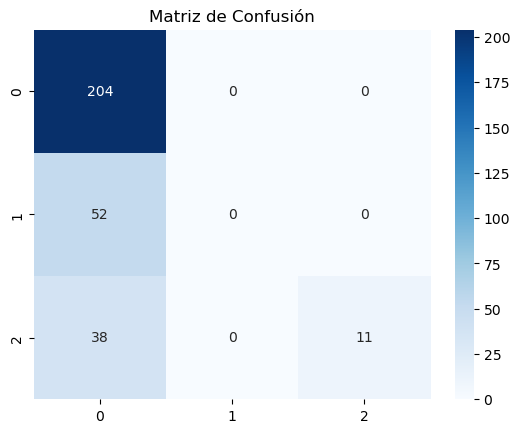

Precisión del modelo en los datos de validación: 0.7049180327868853


In [ ]:
# Crear una clase envoltorio para el modelo de Keras
class KerasModel(BaseEstimator, ClassifierMixin):
    def __init__(self, tamano_vocabulario=10000, embedding_dim=64, hidden_units=64, optimizer='adam', epochs=10, batch_size=32):
        self.tamano_vocabulario = tamano_vocabulario
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size

    def build_model(self):
        modelo = Sequential()
        modelo.add(Embedding(input_dim=self.tamano_vocabulario, output_dim=self.embedding_dim))
        modelo.add(GlobalAveragePooling1D())
        modelo.add(Dense(self.hidden_units, activation='relu'))
        modelo.add(Dense(Y.shape[1], activation="softmax"))
        
        optimizer = Adam() if self.optimizer == 'adam' else RMSprop()
        
        modelo.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        return modelo

    def fit(self, X, y):
        self.model = self.build_model()  # Construir el modelo
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X, batch_size=self.batch_size)

x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=0)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

# Definir el espacio de búsqueda de los hiperparámetros
parametros = {
    'tamano_vocabulario': [10000, 15000],
    'embedding_dim': [64, 128],
    'hidden_units': [64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [10],  
    'batch_size': [32] 
}

grid_search = GridSearchCV(estimator=KerasModel(), param_grid=parametros, cv=3)
grid_search.fit(x_train, y_train)  

# Obtener los mejores parámetros y el modelo resultante
mejores_parametros = grid_search.best_params_
mejor_modelo = grid_search.best_estimator_
print("Mejores parámetros:", mejores_parametros)

y_pred_probs = mejor_modelo.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_val_1d = np.squeeze(np.asarray(np.argmax(y_val, axis=1)))

tag = "emb_" + datetime.now().strftime("%Y%m%d-%H%M%S")
modelo_final = mejor_modelo.model 
modelo_final.save(f'modelos/modelo_{tag}.keras')

conf_mat = confusion_matrix(y_val_1d, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

print("Precisión del modelo en los datos de validación:", accuracy_score(y_val_1d, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


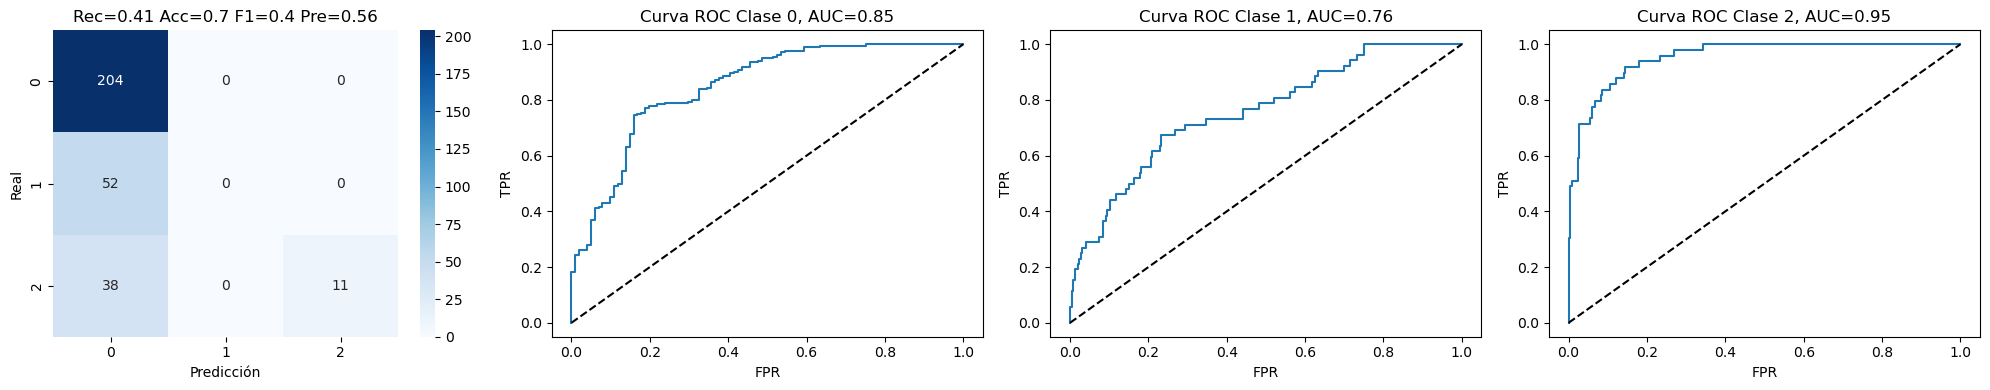

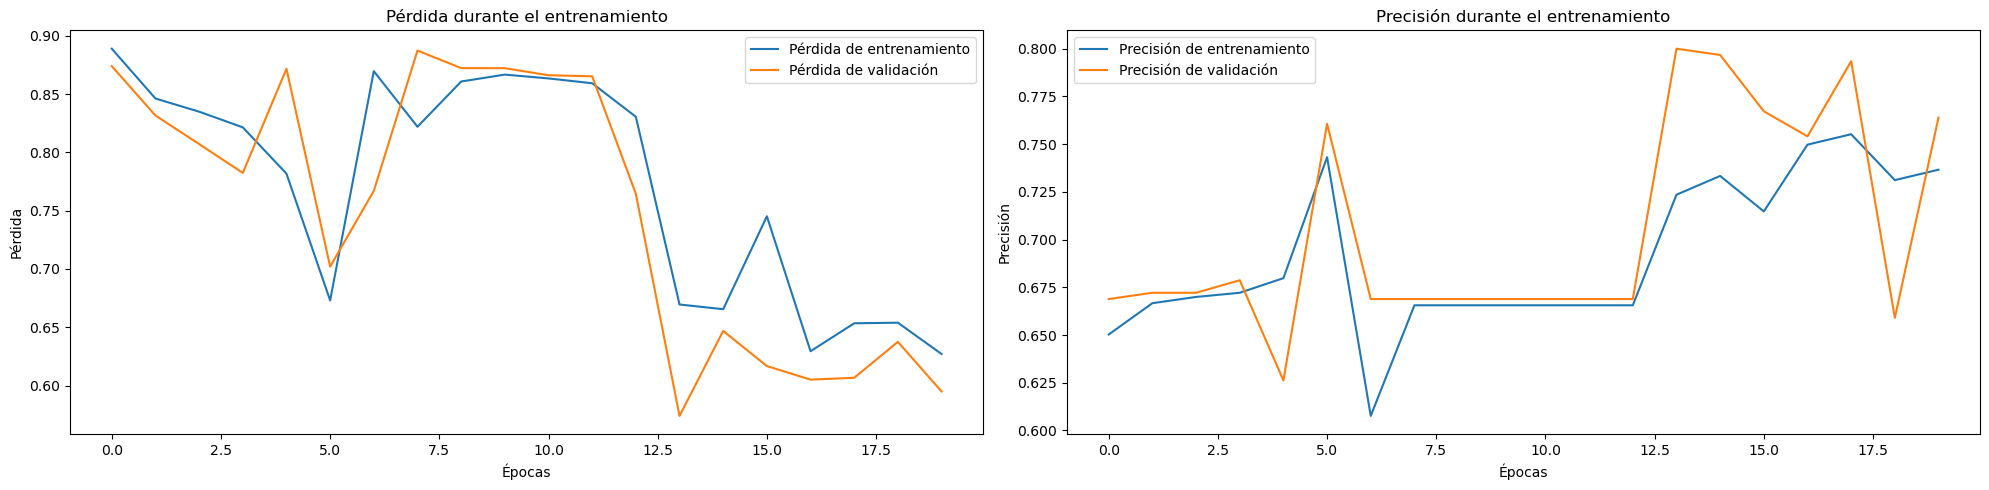

In [116]:
# Obtener las predicciones del modelo final
y_pred = modelo_final.predict(x_val)

# Ajuste de las predicciones de acuerdo a la forma de la salida
if y_pred.shape[1] > 1:
    y_pred_probs = y_pred
else:
    y_pred_probs = np.hstack([1 - y_pred, y_pred])

# Visualización de resultados
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 4)

# 1. Matriz de confusión
matriz = confusion_matrix(y_val_1d, y_pred.argmax(axis=1))  
ax = axes[0]
sns.heatmap(matriz, annot=True, ax=ax, cmap="Blues", fmt="d")
ax.set_title("Rec=" + str(round(recall_score(y_val_1d, y_pred.argmax(axis=1), average="macro"), 2)) +
            " Acc=" + str(round(accuracy_score(y_val_1d, y_pred.argmax(axis=1)), 2)) +
            " F1=" + str(round(f1_score(y_val_1d, y_pred.argmax(axis=1), average="macro"), 2)) +
            " Pre=" + str(round(precision_score(y_val_1d, y_pred.argmax(axis=1), average="macro"), 2)))
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# 2. Curvas ROC para cada una de las clases
fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_pred.shape[1]):  # Número de clases (dinámico en función de la salida del modelo)
    fpr[i], tpr[i], _ = roc_curve(np.asarray(y_val[:, i]), 
                                  np.asarray(y_pred_probs[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Graficamos la curva ROC
    axes[i+1].plot(fpr[i], tpr[i])
    axes[i+1].plot([0, 1], [0, 1], 'k--')
    axes[i+1].set_xlabel('FPR')
    axes[i+1].set_ylabel('TPR')
    axes[i+1].set_title(f'Curva ROC Clase {i}, AUC={round(roc_auc[i], 2)}')

plt.tight_layout()
plt.show()

# Visualización de la precisión, pérdida y curvas ROC
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Pérdida durante el entrenamiento (solo si tienes `historia_final` del ajuste)
axes[0].plot(historia_final.history['loss'], label='Pérdida de entrenamiento')
axes[0].plot(historia_final.history['val_loss'], label='Pérdida de validación')
axes[0].set_title('Pérdida durante el entrenamiento')
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Pérdida')
axes[0].legend()

# Precisión durante el entrenamiento (solo si tienes `historia_final` del ajuste)
axes[1].plot(historia_final.history['accuracy'], label='Precisión de entrenamiento')
axes[1].plot(historia_final.history['val_accuracy'], label='Precisión de validación')
axes[1].set_title('Precisión durante el entrenamiento')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Precisión')
axes[1].legend()

plt.tight_layout()
plt.show()


### Modelo 3 Mejores parametros

In [ ]:
# Definir función para construir el modelo Transformer
def crear_modelo(tamano_vocabulario=10000, num_heads=2, key_dim=32, dense_units=64, dropout_rate=0.1):
    inputs = Input(shape=(X.shape[1],))
    embedding = Embedding(input_dim=tamano_vocabulario, output_dim=64)(inputs)

    # Bloque de atención
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(embedding, embedding)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # Red neuronal feed-forward
    ff = Dense(dense_units, activation="relu")(attention)
    ff = Dense(dense_units)(ff)
    ff = Dropout(dropout_rate)(ff)
    ff = LayerNormalization(epsilon=1e-6)(ff)

    # Capa final
    pooling = GlobalAveragePooling1D()(ff)
    outputs = Dense(Y.shape[1], activation="softmax")(pooling)

    # Construcción del modelo
    modelo_transformer = Model(inputs=inputs, outputs=outputs)
    
    # Compilación del modelo
    modelo_transformer.compile(optimizer="Adam",
                               loss="categorical_crossentropy",
                               metrics=["accuracy"])  # Aseguramos que 'accuracy' es la métrica correcta
    
    return modelo_transformer

# Definir el grid de hiperparámetros
param_grid = {
    'tamano_vocabulario': [10000, 15000],
    'num_heads': [2, 4],
    'key_dim': [32, 64],
    'dense_units': [64, 128],
    'dropout_rate': [0.1, 0.2]
}

# Generar todas las combinaciones de parámetros
grid = ParameterGrid(param_grid)
resultados = []

for params in grid:
    print(f"Entrenando con parámetros: {params}")
    
    modelo_transformer = crear_modelo(**params)

    # Configurar el entrenamiento
    tag = "transformer_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = "logs/fit/" + tag
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    earlystopping_callback = EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
    
    # Entrenar el modelo
    historia_transformer = modelo_transformer.fit(x_train, y_train,
                                                 validation_data=(x_val, y_val),
                                                 batch_size=32, epochs=16, verbose=2,
                                                 callbacks=[tensorboard_callback, earlystopping_callback])

    # Evaluar el modelo
    y_pred_probs = modelo_transformer.predict(x_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_val_1d = np.squeeze(np.asarray(np.argmax(y_val, axis=1)))

    # Almacenar los resultados
    resultados.append({
        'params': params,
        'accuracy': np.round(historia_transformer.history['val_accuracy'][-1], 4),
        'loss': np.round(historia_transformer.history['val_loss'][-1], 4),
        'f1': f1_score(y_val_1d, y_pred, average="macro"),
        'precision': precision_score(y_val_1d, y_pred, average="macro"),
        'recall': recall_score(y_val_1d, y_pred, average="macro")
    })

resultados_df = pd.DataFrame(resultados)
print(resultados_df)

# Encontrar los mejores parámetros basados en la precisión
mejores_resultados = resultados_df.loc[resultados_df['accuracy'].idxmax()]
print(f"Mejores parámetros: {mejores_resultados['params']}")

# Entrenar el mejor modelo con los mejores parámetros encontrados
mejores_parametros = mejores_resultados['params']
mejor_modelo = crear_modelo(**mejores_parametros)

# Entrenar el mejor modelo
mejor_modelo.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=16)

# Guardar el mejor modelo
mejor_modelo.save(f'modelos/modelo_transformer_best_{datetime.now().strftime("%Y%m%d-%H%M%S")}.keras')


Entrenando con parámetros: {'dense_units': 64, 'dropout_rate': 0.1, 'key_dim': 32, 'num_heads': 2, 'tamano_vocabulario': 10000}
Epoch 1/16
29/29 - 4s - 124ms/step - accuracy: 0.6645 - loss: 0.9111 - val_accuracy: 0.6689 - val_loss: 0.8776
Epoch 2/16
29/29 - 1s - 18ms/step - accuracy: 0.6656 - loss: 0.8684 - val_accuracy: 0.6689 - val_loss: 0.8737
Epoch 3/16
29/29 - 1s - 18ms/step - accuracy: 0.6656 - loss: 0.8714 - val_accuracy: 0.6689 - val_loss: 0.8466
Epoch 4/16
29/29 - 1s - 18ms/step - accuracy: 0.6678 - loss: 0.8296 - val_accuracy: 0.6754 - val_loss: 0.7486
Epoch 5/16
29/29 - 1s - 18ms/step - accuracy: 0.7650 - loss: 0.5914 - val_accuracy: 0.8230 - val_loss: 0.4236
Epoch 6/16
29/29 - 1s - 18ms/step - accuracy: 0.9093 - loss: 0.3089 - val_accuracy: 0.9279 - val_loss: 0.2685
Epoch 7/16
29/29 - 1s - 18ms/step - accuracy: 0.9344 - loss: 0.1979 - val_accuracy: 0.9180 - val_loss: 0.2775
Epoch 8/16
29/29 - 1s - 19ms/step - accuracy: 0.9366 - loss: 0.1866 - val_accuracy: 0.9082 - val_loss

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


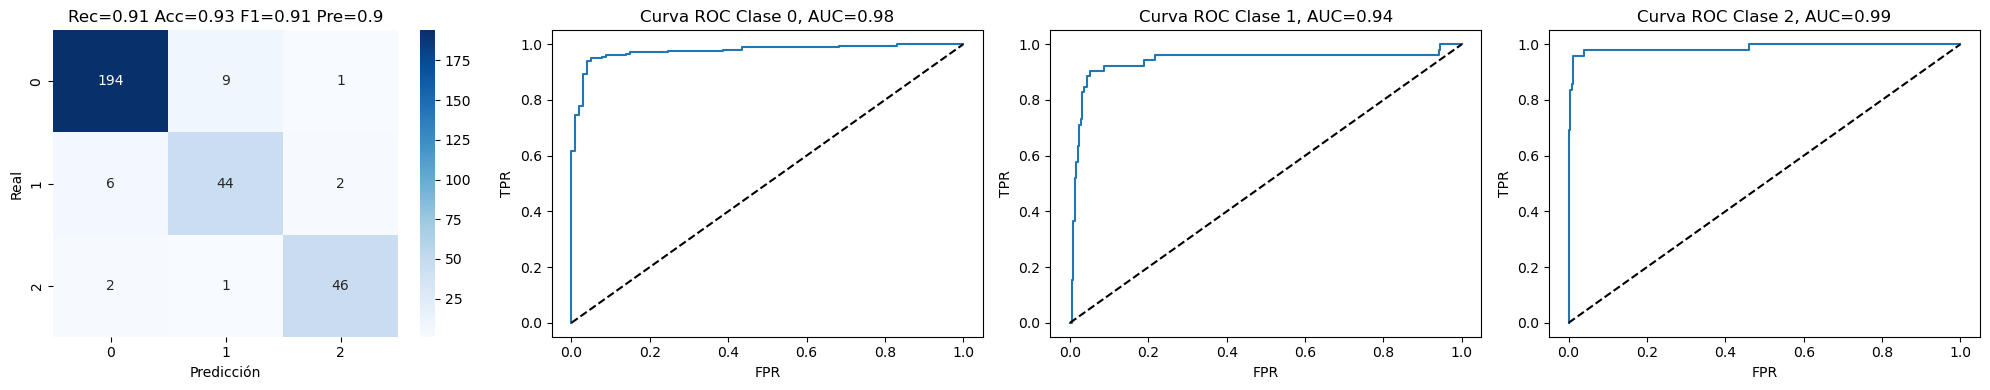

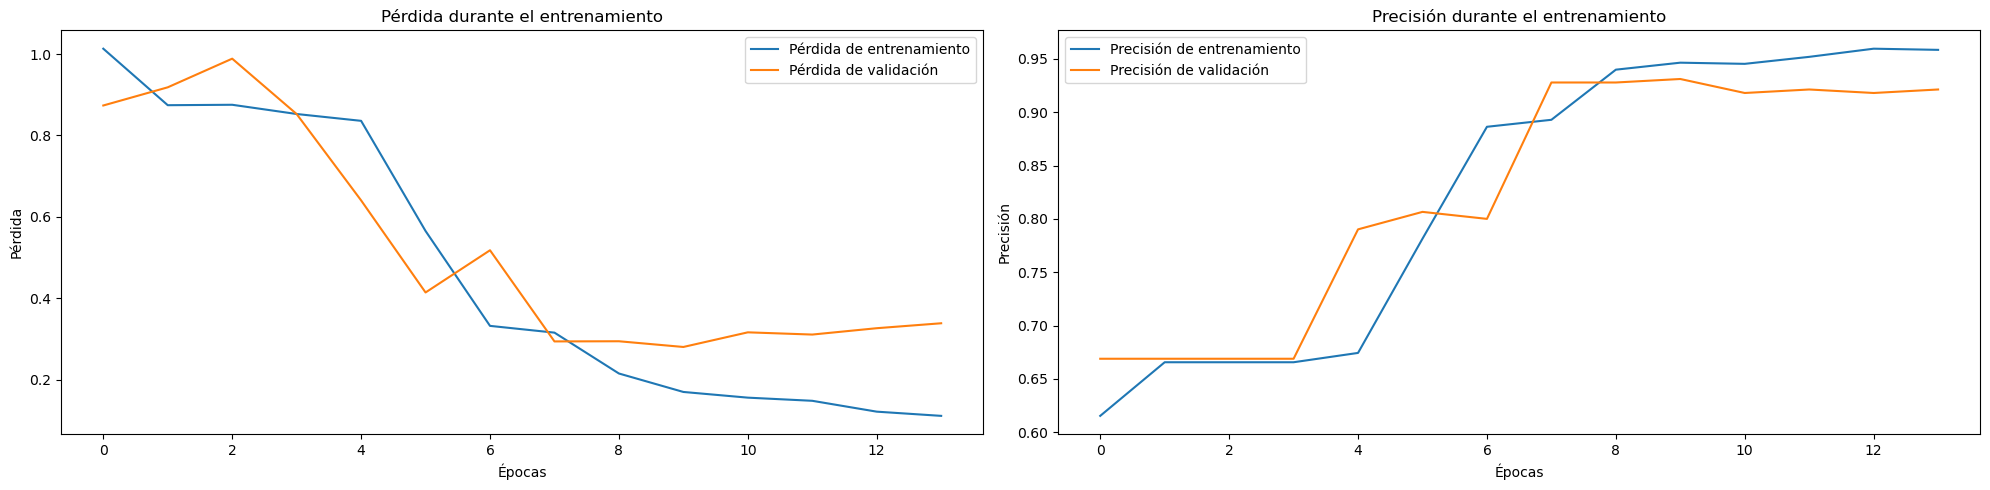

In [119]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_probs = modelo_transformer.predict(x_val)

if y_pred_probs.shape[1] > 1:
    y_pred = y_pred_probs
else:
    y_pred = np.hstack([1 - y_pred_probs, y_pred_probs])

y_val_1d = np.squeeze(np.asarray(np.argmax(y_val, axis=1)))

# Visualización de resultados
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 4)

# Matriz de confusión
matriz = confusion_matrix(y_val_1d, y_pred.argmax(axis=1))  
ax = axes[0]
sns.heatmap(matriz, annot=True, ax=ax, cmap="Blues", fmt="d")
ax.set_title("Rec=" + str(round(recall_score(y_val_1d, y_pred.argmax(axis=1), average="macro"), 2)) +
            " Acc=" + str(round(accuracy_score(y_val_1d, y_pred.argmax(axis=1)), 2)) +
            " F1=" + str(round(f1_score(y_val_1d, y_pred.argmax(axis=1), average="macro"), 2)) +
            " Pre=" + str(round(precision_score(y_val_1d, y_pred.argmax(axis=1), average="macro"), 2)))
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

#  Curvas ROC 
fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_pred.shape[1]):  
    fpr[i], tpr[i], _ = roc_curve(np.asarray(y_val[:, i]), np.asarray(y_pred_probs[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

    #Curva ROC
    axes[i+1].plot(fpr[i], tpr[i])
    axes[i+1].plot([0, 1], [0, 1], 'k--')
    axes[i+1].set_xlabel('FPR')
    axes[i+1].set_ylabel('TPR')
    axes[i+1].set_title(f'Curva ROC Clase {i}, AUC={round(roc_auc[i], 2)}')

plt.tight_layout()
plt.show()

# Visualización de la precisión, pérdida y curvas ROC
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Pérdida durante el entrenamiento 
axes[0].plot(historia_transformer.history['loss'], label='Pérdida de entrenamiento')
axes[0].plot(historia_transformer.history['val_loss'], label='Pérdida de validación')
axes[0].set_title('Pérdida durante el entrenamiento')
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Pérdida')
axes[0].legend()

# Precisión durante el entrenamiento 
axes[1].plot(historia_transformer.history['accuracy'], label='Precisión de entrenamiento')
axes[1].plot(historia_transformer.history['val_accuracy'], label='Precisión de validación')
axes[1].set_title('Precisión durante el entrenamiento')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Precisión')
axes[1].legend()

plt.tight_layout()
plt.show()
